### Init training pipeline with new models

#### Sub-modules 
- [har-imu-transformer](https://github.com/yolish/har-with-imu-transformer/tree/main)
- [sgn skeleton encoder](https://github.com/microsoft/SGN/tree/master)
- custom skeleton decoder

#### Training
- train with matching and non-matching IMU and skeleton pairs
- 


In [1]:
import os 
import sys
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
# import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

sys.path.append('../')
from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator


C:\Users\nipun\AppData\Local\Temp\ipykernel_1552\4166601334.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

---
Data Load

In [3]:
data_root = 'G:/FYP/Codebases/Pose-AE/data'

In [4]:
dataReader = PAMAP2ReaderV2(data_root+'/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\DUET\notebooks\..\src\datasets\data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [5]:
skeleton_data = np.load(data_root+'/skeleton_k10_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

print(skeleton_mov.shape)
print(np.unique(skeleton_classes, return_counts=True))
print(dataReader.label_map)
print(np.unique(skeleton_classes, return_counts=True))

(180, 60, 36)
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10], dtype=int64))
[(1, 'lying'), (2, 'sitting'), (3, 'standing'), (4, 'walking'), (5, 'running'), (6, 'cycling'), (7, 'Nordic walking'), (9, 'watching TV'), (10, 'computer work'), (11, 'car driving'), (12, 'ascending stairs'), (13, 'descending stairs'), (16, 'vacuum cleaning'), (17, 'ironing'), (18, 'folding laundry'), (19, 'house cleaning'), (20, 'playing soccer'), (24, 'rope jumping')]
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playin

In [6]:
skeleton_mov.shape

(180, 60, 36)

In [7]:
action2label = {i:j for i,j in enumerate(dataReader.idToLabel)}
action2label

{0: 'lying',
 1: 'sitting',
 2: 'standing',
 3: 'walking',
 4: 'running',
 5: 'cycling',
 6: 'Nordic walking',
 7: 'watching TV',
 8: 'computer work',
 9: 'car driving',
 10: 'ascending stairs',
 11: 'descending stairs',
 12: 'vacuum cleaning',
 13: 'ironing',
 14: 'folding laundry',
 15: 'house cleaning',
 16: 'playing soccer',
 17: 'rope jumping'}

In [8]:
dataReader.idToLabel

['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic walking',
 'watching TV',
 'computer work',
 'car driving',
 'ascending stairs',
 'descending stairs',
 'vacuum cleaning',
 'ironing',
 'folding laundry',
 'house cleaning',
 'playing soccer',
 'rope jumping']

In [9]:
data_dict = dataReader.generate(unseen_classes=[0,1,2,3,4,5], seen_ratio=0.8, unseen_ratio=0.1, window_size=12, window_overlap=10, resample_freq=50)

In [10]:
class BaseDataset(Dataset):
    def __init__(self, imu_data, imu_actions, skel_data, skel_label, action2label, active_cls, skel_len=120):
        super(BaseDataset, self).__init__()
        self.imu_data = torch.from_numpy(imu_data)
        self.imu_actions = imu_actions
        new_fts = [i for i in range(skel_data.shape[-1]) if i%3 != 2]
        self.skel_data = torch.from_numpy(skel_data[:, :skel_len, new_fts])
        self.skel_label = skel_label
        self.action2label = action2label
        # build action to id mapping dict
        self.skel_len = skel_len
        self.active_cls = active_cls
        self.n_action = len(self.active_cls)
        self.action2Id = dict(zip(active_cls, range(self.n_action)))
        self.Id2action = dict(zip(range(self.n_action), active_cls))
        self.__setup_skel_dict()
    
    def __setup_skel_dict(self):
        action_dict = defaultdict(list)
        for i, c in enumerate(self.skel_label):
            if c in self.active_cls:
                action_dict[c].append(self.skel_data[i])
        
        self.skel_dict = action_dict #{i: np.array(j) for i,j in action_dict.items()}

    def __get_skel(self, anchor_id, flip):
        if flip:
            lbl_ind = anchor_id
        else:
            lbl_ind = random.randint(0, self.n_action)
            # lbl_ind = self.n_action - anchor_id - 1  # has to update

        lbl = self.Id2action[lbl_ind]
        ind = random.randint(0, 10) # has to update
        skel = self.skel_dict[lbl][ind]
        return skel 
        

    def __getitem__(self, ind):
        x = self.imu_data[ind, ...]
        anchor_action = self.imu_actions[ind]
        anchor_label = self.action2label[anchor_action]
        anchor_id = self.action2Id[anchor_label]
        
        y = random.randint(0, 2)
        skel = self.__get_skel(anchor_id, y)
        return x, y, skel

    def __len__(self):
        return self.imu_data.shape[0]


In [11]:
act_c = ['Nordic walking', 'watching TV', 'computer work', 'car driving', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'house cleaning', 'playing soccer', 'rope jumping']
dataset = BaseDataset(imu_data=data_dict['train']['X'], imu_actions=data_dict['train']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=act_c, skel_len=60)


In [12]:
np.unique(data_dict['train']['y'])

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [13]:
dl =  DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)

In [14]:
for xi,yi,skeli in dl:
    print(xi.shape, yi.shape, skeli.shape)
    print(yi)
    break

torch.Size([32, 24, 54]) torch.Size([32]) torch.Size([32, 60, 24])
tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 1])


In [15]:
class UnseenDataset(Dataset):
    def __init__(self, imu_data, imu_actions, skel_data, skel_label, action2label, active_cls, skel_len=120):
        super(UnseenDataset, self).__init__()
        self.imu_data = torch.from_numpy(imu_data)
        self.imu_actions = imu_actions
        new_fts = [i for i in range(skel_data.shape[-1]) if i%3 != 2]
        self.skel_data = skel_data[:, :skel_len, new_fts]
        self.skel_label = skel_label
        self.action2label = action2label
        # build action to id mapping dict
        self.skel_len = skel_len
        self.active_cls = active_cls
        self.n_action = len(self.active_cls)
        self.action2Id = dict(zip(active_cls, range(self.n_action)))
        self.Id2action = dict(zip(range(self.n_action), active_cls))
        self.__setup_skel_dict()

    def __setup_skel_dict(self):
        action_dict = defaultdict(list)
        for i, c in enumerate(self.skel_label):
            if c in self.active_cls:
                action_dict[c] = self.skel_data[i]
        
        self.skel_dict = action_dict
        self.skel_anchor = torch.from_numpy(np.array([action_dict[i] for i in self.active_cls]))

    def __getitem__(self, ind):
        x = self.imu_data[ind, ...]
        anchor_action = self.imu_actions[ind]
        anchor_label = self.action2label[anchor_action]
        anchor_id = self.action2Id[anchor_label]
        
        return x, anchor_id, self.skel_anchor

    def __len__(self):
        return self.imu_data.shape[0]

In [16]:
unseen_cls = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling']
unseen_dt = UnseenDataset(imu_data=data_dict['test']['X'], imu_actions=data_dict['test']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=unseen_cls, skel_len=60)

unseen_dl =  DataLoader(unseen_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)

In [17]:
for ux, uy, uskels in unseen_dl:
    print(ux.shape, uy.shape, uskels.shape)
    break

torch.Size([32, 24, 54]) torch.Size([32]) torch.Size([32, 6, 60, 24])


---
Model Building

In [18]:
from src.models.modeling_sgn import embed, local, gcn_spa, compute_g_spa
from src.models.modeling_lxmert import LxmertConfig, LxmertXLayer
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from src.models.bidirectional_cross_attention import BidirectionalCrossAttention
import math

In [19]:
class SGNEncoder(nn.Module):
    def __init__(self, num_joint, seg, hidden_size=128, bs=32, is_3d=True, train=True, bias=True, device='cpu'):
        super(SGNEncoder, self).__init__()

        self.dim1 = hidden_size
        self.dim_unit = hidden_size // 4 
        self.seg = seg
        self.num_joint = num_joint
        self.bs = bs

        if is_3d:
          self.spatial_dim = 3
        else:
          self.spatial_dim = 2

        if train:
            self.spa = self.one_hot(bs, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(bs, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)
        else:
            self.spa = self.one_hot(32 * 5, num_joint, self.seg)
            self.spa = self.spa.permute(0, 3, 2, 1).to(device)
            self.tem = self.one_hot(32 * 5, self.seg, num_joint)
            self.tem = self.tem.permute(0, 3, 1, 2).to(device)

        self.tem_embed = embed(self.seg, joint=self.num_joint, hidden_dim=self.dim_unit*4, norm=False, bias=bias)
        self.spa_embed = embed(num_joint, joint=self.num_joint, hidden_dim=self.dim_unit, norm=False, bias=bias)
        self.joint_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.dif_embed = embed(self.spatial_dim, joint=self.num_joint, hidden_dim=self.dim_unit, norm=True, bias=bias)
        self.maxpool = nn.AdaptiveMaxPool2d([1, 1])
        self.cnn = local(self.dim1, self.dim1 * 2, bias=bias)
        self.compute_g1 = compute_g_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn1 = gcn_spa(self.dim1 // 2, self.dim1 // 2, bias=bias)
        self.gcn2 = gcn_spa(self.dim1 // 2, self.dim1, bias=bias)
        self.gcn3 = gcn_spa(self.dim1, self.dim1, bias=bias)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

        nn.init.constant_(self.gcn1.w.cnn.weight, 0)
        nn.init.constant_(self.gcn2.w.cnn.weight, 0)
        nn.init.constant_(self.gcn3.w.cnn.weight, 0)


    def forward(self, x):
        
        # Dynamic Representation
        x = x.view((self.bs, self.seg, self.num_joint, self.spatial_dim))
        x = x.permute(0, 3, 2, 1).contiguous()
        dif = x[:, :, :, 1:] - x[:, :, :, 0:-1]
        dif = torch.cat([dif.new(self.bs, dif.size(1), self.num_joint, 1).zero_(), dif], dim=-1)
        # print(x.shape)
        pos = self.joint_embed(x)
        tem1 = self.tem_embed(self.tem)
        spa1 = self.spa_embed(self.spa)
        dif = self.dif_embed(dif)
        dy = torch.add(pos, dif)
        # Joint-level Module
        x= torch.cat([dy, spa1], 1)
        g = self.compute_g1(x)
        x = self.gcn1(x, g)
        x = self.gcn2(x, g)
        x = self.gcn3(x, g)
        # Frame-level Module
        x = torch.add(x, tem1)
        x = self.cnn(x)
        output_feat = torch.squeeze(x).permute(0,2,1).contiguous()

        return output_feat

    def one_hot(self, bs, spa, tem):

        y = torch.arange(spa).unsqueeze(-1)
        y_onehot = torch.FloatTensor(spa, spa)

        y_onehot.zero_()
        y_onehot.scatter_(1, y, 1)

        y_onehot = y_onehot.unsqueeze(0).unsqueeze(0)
        y_onehot = y_onehot.repeat(bs, tem, 1, 1)

        return y_onehot

    
# class BiLSTMDecoder(nn.Module):
#     def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True, device='cpu'):
#         super(BiLSTMDecoder, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.device = device
#         self.num_layers = num_layers
#         self.linear_filters = linear_filters[::-1]
#         self.embedding_size = embedding_size
#         self.bidirectional = bidirectional
#         self.seq_len = seq_len

#         # define LSTM layer
#         self.layers = []
#         # add lstm
#         self.lstm = nn.LSTM(input_size = self.seq_len, hidden_size = self.hidden_size,
#                             num_layers = self.num_layers, bidirectional=True,
#                             batch_first=True)
        
#         self.maxpool = nn.AdaptiveMaxPool2d([self.seq_len, self.seq_len])
#         # add linear layers 
#         if bidirectional:
#             self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
#         else:
#             self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

#         for __id,layer_in in enumerate(self.linear_filters):
#             if __id == len(linear_filters)-1:
#                 self.layers.append(nn.Linear(layer_in,self.input_size))
#             else:
#                 self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

#         self.net = nn.Sequential(*self.layers)


#     def forward(self,encoder_hidden):
#         """
#         : param x_input:               input of shape (seq_len, # in batch, input_size)
#         : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
#         """
#         output = self.maxpool(encoder_hidden)
#         lstm_out, _ = self.lstm(output)
#         x = self.net(lstm_out)
#         return x

In [20]:
class BiLSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, bidirectional=True, batch_size=32, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.device = device

        # add lstm layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True, proj_size = output_size)

        
    def forward(self, x):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        # x = self.net(x_input)
        out, _ = self.lstm(x)
        return out

In [21]:
class IMUTransformerEncoder(nn.Module):

    def __init__(self, config):
        """
        config: (dict) configuration of the model
        """
        super().__init__()

        self.transformer_dim = config.get("transformer_dim")

        self.input_proj = nn.Sequential(nn.Conv1d(config.get("input_dim"), self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU(),
                                        nn.Conv1d(self.transformer_dim, self.transformer_dim, 1), nn.GELU())

        self.window_size = config.get("window_size")
        self.encode_position = config.get("encode_position")
        encoder_layer = TransformerEncoderLayer(d_model = self.transformer_dim,
                                       nhead = config.get("nhead"),
                                       dim_feedforward = config.get("dim_feedforward"),
                                       dropout = config.get("transformer_dropout"),
                                       activation = config.get("transformer_activation"))

        self.transformer_encoder = TransformerEncoder(encoder_layer,
                                              num_layers = config.get("num_encoder_layers"),
                                              norm = nn.LayerNorm(self.transformer_dim))
        self.cls_token = nn.Parameter(torch.zeros((1, self.transformer_dim)), requires_grad=True)

        if self.encode_position:
            self.position_embed = nn.Parameter(torch.randn(self.window_size + 1, 1, self.transformer_dim))

        # num_classes =  config.get("num_classes")
        output_size = config.get("output_size")
        self.imu_head = nn.Sequential(
            nn.AvgPool2d((self.window_size,1)),
            nn.Linear(self.transformer_dim,  output_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(output_size, output_size)
        )
        self.sigmoid = nn.Sigmoid()

        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, data):
        src = data  # Shape N x S x C with S = sequence length, N = batch size, C = channels
        src = self.input_proj(src.transpose(1, 2)).permute(2, 0, 1)

        cls_token = self.cls_token.unsqueeze(1).repeat(1, src.shape[1], 1)
        src = torch.cat([cls_token, src])

        if self.encode_position:
            src += self.position_embed

        target = self.transformer_encoder(src)
        target = torch.squeeze(target.permute(1,0,2))
        target = self.imu_head(target)
        return target

def get_activation(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return nn.ReLU(inplace=True)
    if activation == "gelu":
        return nn.GELU()
    raise RuntimeError("Activation {} not supported".format(activation))

In [22]:
# class IMUEncoder(nn.Module):
#     def __init__(self, in_ft, d_model, ft_size, num_heads=1, max_len=1024, dropout=0.1):
#         super(IMUEncoder, self).__init__()
#         self.in_ft = in_ft
#         self.max_len = max_len
#         self.d_model = d_model
#         self.num_heads = num_heads
#         self.ft_size = ft_size 

#         self.lstm = nn.LSTM(input_size=self.in_ft,
#                             hidden_size=self.d_model,
#                             num_layers=self.num_heads,
#                             batch_first=True,
#                             bidirectional=True,
#                             dropout=dropout)
#         self.drop = nn.Dropout(p=0.1)
#         self.act = nn.ReLU()
#         self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
#         # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out_forward = out[:, self.max_len - 1, :self.d_model]
#         out_reverse = out[:, 0, self.d_model:]
#         out_reduced = torch.cat((out_forward, out_reverse), 1)
#         out = self.drop(out_reduced)
#         out = self.act(out)
#         out = self.fcLayer1(out)
#         out = torch.unsqueeze(out, 1)
#         # out = self.fcLayer2(out)
#         return out

In [23]:
class ClassifierHead(nn.Module):
  def __init__(self, embedding_size):
        super(ClassifierHead, self).__init__()
        #   self.maxpool = nn.AdaptiveMaxPool2d([embedding_size//2, 2])
      #   self.hidden = nn.Linear(embedding_size, embedding_size)
      #   self.relu = nn.ReLU()
        self.linear = nn.Linear(embedding_size, 1)
        self.sigmoid = nn.Sigmoid()

  def forward(self, x):
        x = self.linear(x)
        # x = torch.squeeze(x)
        x = self.sigmoid(x)
        out = torch.squeeze(x)
        return out

In [24]:
class BaseModel(nn.Module):
    def __init__(self, config):
        super(BaseModel, self).__init__()
        self.device = config['device']
        self.imu_model = IMUTransformerEncoder(config['imu_config'])
        self.skel_encoder = SGNEncoder(**config['sgn_config'])
        self.skel_decoder = BiLSTMDecoder(**config['dec_config'])
        self.fc_head = ClassifierHead(config["ft_size"])
        self.lxmert_xlayer = BidirectionalCrossAttention(**config['xmert_config'])

        self.imu_mask = torch.ones((config['bs'], config['imu_len']), requires_grad=True).bool().to(self.device)
        self.skel_mask = torch.ones((config['bs'], config['skel_len']), requires_grad=True).bool().to(self.device)
        

    def forward(self, x_imu, x_skel):
        imu_feats = self.imu_model(x_imu)
        skel_feats = self.skel_encoder(x_skel)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")

        imu_feats, skel_feats = self.lxmert_xlayer(imu_feats, skel_feats, mask=self.imu_mask, context_mask=self.skel_mask)
        # print(f"imu_feats {imu_feats.shape} | skel_feats {skel_feats.shape}")
        skel_recon = self.skel_decoder(skel_feats)
        bin_output = self.fc_head(imu_feats[:, 0, :])
        return bin_output, skel_recon

In [25]:
imu_config = {
	"input_dim": 54,
    "window_size":24,
	"encode_position":True,
	"transformer_dim": 256,
	"nhead": 8,
	"num_encoder_layers": 6, 
	"dim_feedforward": 128, 
	"transformer_dropout": 0.1, 
	"transformer_activation": "gelu",
	"head_activation": "gelu",
    "baseline_dropout": 0.1,
	"batch_size": 32,
	"output_size": 512
}

imuenc_config = {
    'in_ft': 54,
    'd_model': 256,
    'ft_size': 512,
    'num_heads': 2,
    'max_len': 24,
    'dropout': 0.1
}

sgn_config = {
    'num_joint': 12,
    'seg': 60,
    'hidden_size': 256,
    'train': True,
    'bs': 32,
    'is_3d': False
}

# dec_config = {
#     'seq_len': 60,
#     'input_size': 24,
#     'hidden_size': 256,
#     'num_layers': 2,
#     'bidirectional': True,
#     "embedding_size": 128,
#     "linear_filters":[128,256,512,1024],
# }

dec_config = {
    'input_size': 512,
    'hidden_size': 256,
    'num_layers': 2,
    'output_size': 24,
    'bidirectional': False
}

base_config = {
    'imu_config': imu_config,
    'sgn_config': sgn_config,
    'dec_config': dec_config,
    'device': 'cpu',
    'bs': 32,
    'imu_len': 1,
    'skel_len': 60,
    'ft_size': 512,
    'xmert_config': {
            'dim': 512,
            'heads': 8,
            'dim_head': 64,
            'context_dim': 512,   
            
    }
}
 
base_model = BaseModel(base_config)

In [26]:
imu_output, skel_recon = base_model(xi.float().requires_grad_(), skeli.float().requires_grad_())

c:\Users\nipun\anaconda3\envs\fyp_env\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: LSTM with projections is not supported with oneDNN. Using default implementation. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\RNN.cpp:1464.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [27]:
print(imu_output.shape, skel_recon.shape)

torch.Size([32]) torch.Size([32, 60, 24])


In [28]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            try:
                ave_grads.append(p.grad.abs().mean())
            except:
                print(n, p.grad)
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [29]:
# def plot_grad_flow(named_parameters):
#     ave_grads = []
#     layers = []
#     for n, p in named_parameters:
#         if(p.requires_grad) and ("bias" not in n):
#             layers.append(n)
#             ave_grads.append(p.grad.abs().mean())

#     plt.plot(ave_grads, alpha=0.3, color="b")
#     plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
#     plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
#     plt.xlim(xmin=0, xmax=len(ave_grads))
#     plt.xlabel("Layers")
#     plt.ylabel("average gradient")
#     plt.title("Gradient flow")
#     plt.grid(True)

In [30]:
# plot_grad_flow(base_model.named_parameters())

---
Training Pipeline

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [54]:
def train_step(model, dl, optimizer, loss_modules, device, phase='train', loss_alpha=0.7):
    model = model.train()

    with tqdm(dl, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            X, y, skel = batch 
            X = X.float().to(device)
            y = y.float().to(device)
            skel = skel.float().to(device)
            # print(f"X : {X.shape} | skel : {skel.shape}")

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                cls_prob, skel_recon = model(X, skel)
                # print("cls_prob : ", cls_prob.shape, " skel_recon :", skel_recon.shape)
                class_loss = loss_modules['classi'](cls_prob, y)
                recon_loss = loss_modules['recon'](skel, skel_recon)

            # print(f" Check for nan | X : {torch.isnan(X).sum()} | X-inf : {torch.isinf(X).sum()} | skel : {torch.isnan(skel).sum()} | skel-inf : {torch.isinf(skel).sum()} | cls_prob : {torch.isnan(cls_prob).sum()} | skel_recon : {torch.isnan(skel_recon).sum()}")
            # print("class loss : ", class_loss.item(), " recon_loss : ", recon_loss.item())
            loss = (1-loss_alpha)*class_loss + loss_alpha*recon_loss
            # loss = class_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            # for name, param in model.named_parameters():
            #     print(name, param.grad.max())

            metrics = {"loss": loss.item(), 'classi. loss': class_loss.item(), 'recon. loss': recon_loss.item()}
            tepoch.set_postfix({"loss": loss.item(), 'classi. loss': class_loss.item(), 'recon. loss': recon_loss.item()})
            # pred_class = cls_prob.cpu().detach().numpy()
            y_pred = (cls_prob.cpu().detach().numpy() >= 0.5).astype(int)
            # print("y_true : ", y.cpu().detach().numpy().astype(int), " y_pred : ", pred_class)
            metrics["accuracy"] = accuracy_score(y_true=y.cpu().detach().numpy().astype(int), y_pred=y_pred)
            
        return metrics 

In [55]:
def validate_step(model, dl, optimizer, loss_modules, device, class_names, phase='train', loss_alpha=0.7, print_report=False, show_plot=False):
    model = model.eval()
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "recon. loss": 0, "classi. loss": 0}

    with tqdm(dl, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            X, y, skel = batch 
            X = X.float().to(device)
            y = y.float().to(device)
            skel = skel.float().to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                cls_prob, skel_recon = model(X, skel)
                class_loss = loss_modules['classi'](cls_prob, y)
                recon_loss = loss_modules['recon'](skel, skel_recon)

            loss = loss_alpha*class_loss + recon_loss

            with torch.no_grad():
                metrics['samples'] += len(y)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['recon. loss'] += recon_loss.item()
                metrics['classi. loss'] += class_loss.item()

            y_pred = (cls_prob.cpu().detach().numpy() >= 0.5).astype(int)
            per_batch['targets'].append(y.cpu().numpy())
            per_batch['predictions'].append(y_pred)
            per_batch['metrics'].append([loss.detach().cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets.astype(int), class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [56]:
def unseen_eval(model, unseen_dl, device, class_names, print_report=True, show_plot=True):
    model = model.eval()
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': [], 'feat': []}
    metrics = {"samples": 0, "loss": 0, "recon. loss": 0, "classi. loss": 0}

    with tqdm(unseen_dl, unit='batch') as tepoch:
        for batch in tepoch:
            X, y, skels = batch 
            X = X.float().to(device)
            y = y.float()
            skels = skels.float().to(device)

        skels = skels.permute(1,0,2,3)
        preds = []
        for i in range(len(class_names)):
            with torch.no_grad():
                cls_prob, skel_recon = model(X, skels[i, ...])
                preds.append(cls_prob.cpu().detach().numpy())
            
        preds = np.array(preds)
        # print("preds shape : ", preds.shape)
        per_batch['targets'].append(y.cpu().numpy())
        per_batch['predictions'].append(preds)

    all_preds = np.argmax(np.concatenate(per_batch["predictions"]).T, axis=-1)
    all_targets = np.concatenate(per_batch["targets"]).astype(int)
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report, show_plot=show_plot)

    return metrics_dict

In [57]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['recon. loss'] = df['recon. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='recon. loss', hue='phase', marker='o', ax=axs[0]).set(title="Reconstruction Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

---
Run

In [65]:
config = {
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "Transfomer-Encder",
    "sem-space": 'I3D',
    # model training configs
    "lr": 0.00001,
    "loss_alpha": 0.1,
    "n_epochs": 15,
    "batch_size": 32,
    # model configs
    "feat_size": 512, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 12, 
    "overlap": 10,
    "freq": 50,
    "seq_len": 60,  # skeleton seq. length
    "seen_split": 0.1,
}

In [66]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
data_dict = dataReader.generate(unseen_classes=[1,2], seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
dl =  DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, drop_last=True)
for x,y,skel in dl:
    _, seq_len, imu_feat = x.shape 
    _, timestamps, joints = skel.shape
    break

In [72]:
imu_config = {
	"input_dim": imu_feat, # 
    "window_size": seq_len, # 
	"encode_position":True,
	"transformer_dim": 256, ##
	"nhead": 8,
	"num_encoder_layers": 6, 
	"dim_feedforward": 128, 
	"transformer_dropout": 0.1, 
	"transformer_activation": "gelu",
	"head_activation": "gelu",
    "baseline_dropout": 0.1,
	"batch_size": 32,
	"output_size": config['feat_size'] ##
}

imuenc_config = {
    'in_ft': imu_feat,
    'd_model': 256,
    'ft_size': config['feat_size'],
    'num_heads': 2,
    'max_len': seq_len,
    'dropout': 0.1
}

sgn_config = {
    'num_joint': joints//2, #
    'seg': timestamps, #
    'hidden_size': config['feat_size']//2, 
    'train': True,
    'bs': config['batch_size'], ##
    'is_3d': False,
    'device': device
}

# dec_config = {
#     'seq_len': timestamps, #
#     'input_size': joints, #
#     'hidden_size': 256, 
#     'num_layers': 2,
#     'bidirectional': True,
#     "embedding_size": 128, ##
#     "linear_filters":[128,256,512,1024],
# }

dec_config = {
    'input_size': config['feat_size'],
    'hidden_size': 256,
    'num_layers': 2,
    'output_size': joints,
    'bidirectional': False
}


base_config = {
    'imu_config': imu_config,
    'sgn_config': sgn_config,
    'dec_config': dec_config,
    'num_layers': 1,
    'device': device,
    'bs': config['batch_size'],
    'imu_len': 1,
    'skel_len': timestamps,
    'ft_size': config['feat_size'],
    'xmert_config': {
        'dim': config['feat_size'],
        'heads': 4,
        'dim_head': 64,
        'context_dim': config['feat_size']#
    }
}



In [73]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [74]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  ['lying', 'sitting', 'walking', 'running', 'cycling', 'Nordic walking', 'computer work', 'car driving', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'playing soccer', 'rope jumping']
unseen classes >  ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
Initiate IMU datasets ...


Training Epoch:   7%|▋         | 1/15 [00:56<13:07, 56.24s/it]

Overall accuracy: 0.565



Training Epoch:  13%|█▎        | 2/15 [01:59<13:07, 60.57s/it]

Overall accuracy: 0.669



Training Epoch:  20%|██        | 3/15 [03:16<13:37, 68.12s/it]

Overall accuracy: 0.745



Training Epoch:  27%|██▋       | 4/15 [04:39<13:30, 73.64s/it]

Overall accuracy: 0.717



Training Epoch:  33%|███▎      | 5/15 [06:03<12:53, 77.37s/it]

Overall accuracy: 0.666



Training Epoch:  40%|████      | 6/15 [07:25<11:51, 79.11s/it]

Overall accuracy: 0.733



Training Epoch:  47%|████▋     | 7/15 [08:35<10:07, 75.99s/it]

Overall accuracy: 0.671



Training Epoch:  53%|█████▎    | 8/15 [09:43<08:35, 73.59s/it]

Overall accuracy: 0.755



Training Epoch:  60%|██████    | 9/15 [10:54<07:15, 72.65s/it]

Overall accuracy: 0.711



train: 100%|██████████| 31/31 [00:02<00:00, 12.78batch/s, loss=0.239]


Overall accuracy: 0.775



Training Epoch:  73%|███████▎  | 11/15 [13:15<04:46, 71.50s/it]

Overall accuracy: 0.777



Training Epoch:  80%|████████  | 12/15 [14:27<03:35, 71.69s/it]

Overall accuracy: 0.751



Training Epoch:  87%|████████▋ | 13/15 [15:38<02:23, 71.55s/it]

Overall accuracy: 0.724



Training Epoch:  93%|█████████▎| 14/15 [16:53<01:12, 72.77s/it]

Overall accuracy: 0.746



train: 100%|██████████| 31/31 [00:02<00:00, 10.68batch/s, loss=0.268]


Overall accuracy: 0.596



100%|██████████| 84/84 [00:00<00:00, 364.73batch/s]


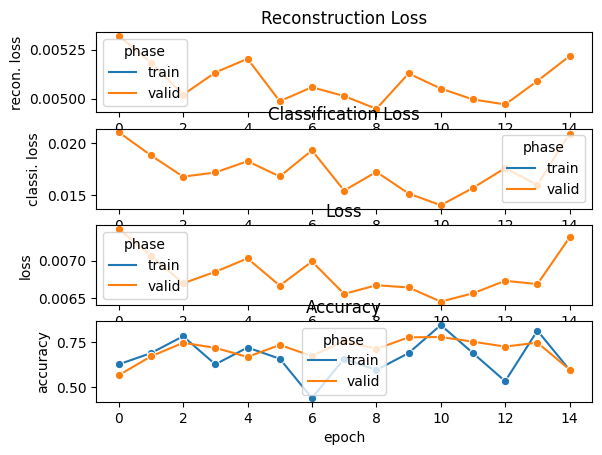

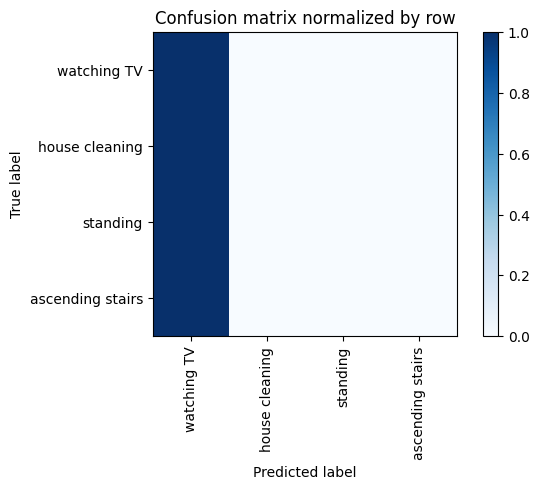

Overall accuracy: 0.125

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.000      0.000      0.000      0.562         18|	 watching TV: 1.000,	ascending stairs: 0.000,	
ascending stairs       0.000      0.000      0.000      0.188          6|	 watching TV: 1.000,	standing: 0.000,	
  house cleaning       0.000      0.000      0.000      0.125          4|	 watching TV: 1.000,	ascending stairs: 0.000,	standing: 0.000,	
     watching TV       0.125      1.000      0.222      0.125          4|	 ascending stairs: 0.000,	standing: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.016      0.125      0.028        1.0         32|	      

{'accuracy': 0.125, 'precision': 0.03125, 'recall': 0.25, 'f1': 0.05555555555555555}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
seen c

Training Epoch:   7%|▋         | 1/15 [01:20<18:44, 80.32s/it]

Overall accuracy: 0.576



Training Epoch:  13%|█▎        | 2/15 [02:32<16:22, 75.61s/it]

Overall accuracy: 0.591



Training Epoch:  20%|██        | 3/15 [03:40<14:26, 72.17s/it]

Overall accuracy: 0.642



Training Epoch:  27%|██▋       | 4/15 [04:47<12:49, 69.94s/it]

Overall accuracy: 0.562



Training Epoch:  33%|███▎      | 5/15 [05:54<11:30, 69.07s/it]

Overall accuracy: 0.552



Training Epoch:  40%|████      | 6/15 [07:03<10:20, 68.99s/it]

Overall accuracy: 0.554



Training Epoch:  47%|████▋     | 7/15 [08:12<09:12, 69.09s/it]

Overall accuracy: 0.576



Training Epoch:  53%|█████▎    | 8/15 [09:35<08:33, 73.43s/it]

Overall accuracy: 0.582



Training Epoch:  60%|██████    | 9/15 [11:05<07:51, 78.50s/it]

Overall accuracy: 0.618



Training Epoch:  67%|██████▋   | 10/15 [12:16<06:21, 76.34s/it]

Overall accuracy: 0.606



Training Epoch:  73%|███████▎  | 11/15 [13:27<04:58, 74.52s/it]

Overall accuracy: 0.608



Training Epoch:  80%|████████  | 12/15 [14:34<03:36, 72.25s/it]

Overall accuracy: 0.595



Training Epoch:  87%|████████▋ | 13/15 [15:40<02:21, 70.58s/it]

Overall accuracy: 0.607



Training Epoch:  93%|█████████▎| 14/15 [16:50<01:10, 70.12s/it]

Overall accuracy: 0.584



train: 100%|██████████| 31/31 [00:02<00:00, 12.18batch/s, loss=0.234]


Overall accuracy: 0.573



100%|██████████| 82/82 [00:00<00:00, 438.78batch/s]


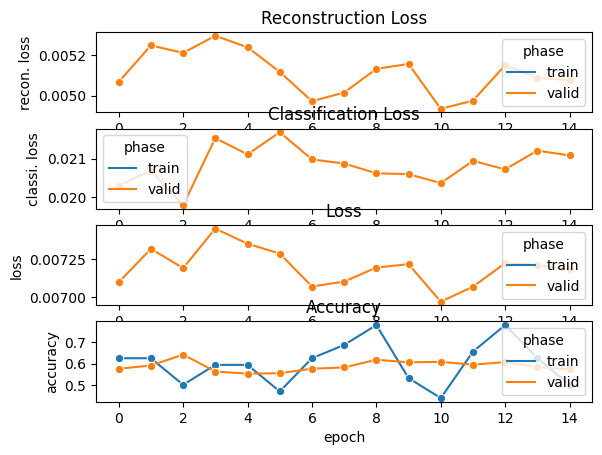

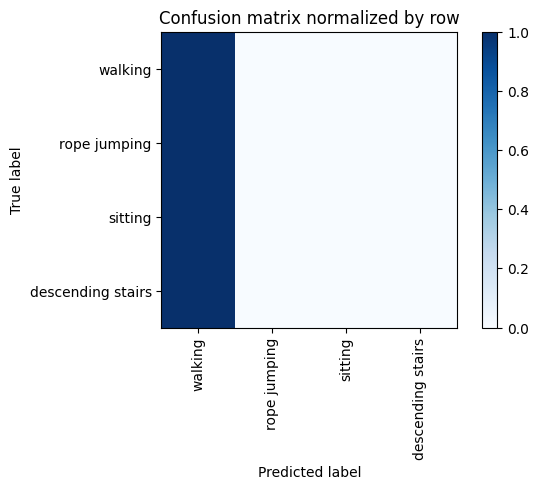

Overall accuracy: 0.344

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          sitting       0.000      0.000      0.000      0.375         12|	 walking: 1.000,	descending stairs: 0.000,	
          walking       0.344      1.000      0.512      0.344         11|	 descending stairs: 0.000,	sitting: 0.000,	
descending stairs       0.000      0.000      0.000      0.188          6|	 walking: 1.000,	sitting: 0.000,	
     rope jumping       0.000      0.000      0.000      0.094          3|	 walking: 1.000,	descending stairs: 0.000,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.118      0.344      0.176        1.0         32|	      

{'accuracy': 0.34375, 'precision': 0.0859375, 'recall': 0.25, 'f1': 0.12790697674418605}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work']
seen

Training Epoch:   7%|▋         | 1/15 [01:01<14:26, 61.87s/it]

Overall accuracy: 0.580



Training Epoch:  13%|█▎        | 2/15 [02:03<13:25, 61.95s/it]

Overall accuracy: 0.594



Training Epoch:  20%|██        | 3/15 [03:04<12:17, 61.47s/it]

Overall accuracy: 0.585



Training Epoch:  27%|██▋       | 4/15 [04:06<11:15, 61.43s/it]

Overall accuracy: 0.601



Training Epoch:  33%|███▎      | 5/15 [05:07<10:12, 61.25s/it]

Overall accuracy: 0.624



Training Epoch:  40%|████      | 6/15 [06:07<09:08, 60.89s/it]

Overall accuracy: 0.583



Training Epoch:  47%|████▋     | 7/15 [07:04<07:56, 59.56s/it]

Overall accuracy: 0.617



Training Epoch:  53%|█████▎    | 8/15 [08:03<06:57, 59.59s/it]

Overall accuracy: 0.608



Training Epoch:  60%|██████    | 9/15 [09:05<06:02, 60.42s/it]

Overall accuracy: 0.614



Training Epoch:  67%|██████▋   | 10/15 [10:08<05:05, 61.12s/it]

Overall accuracy: 0.602



Training Epoch:  73%|███████▎  | 11/15 [11:20<04:17, 64.48s/it]

Overall accuracy: 0.628



Training Epoch:  80%|████████  | 12/15 [12:29<03:17, 65.79s/it]

Overall accuracy: 0.603



Training Epoch:  87%|████████▋ | 13/15 [13:33<02:10, 65.37s/it]

Overall accuracy: 0.580



Training Epoch:  93%|█████████▎| 14/15 [14:33<01:03, 63.65s/it]

Overall accuracy: 0.639



train: 100%|██████████| 29/29 [00:02<00:00, 13.49batch/s, loss=0.202]


Overall accuracy: 0.613



100%|██████████| 108/108 [00:00<00:00, 378.61batch/s]


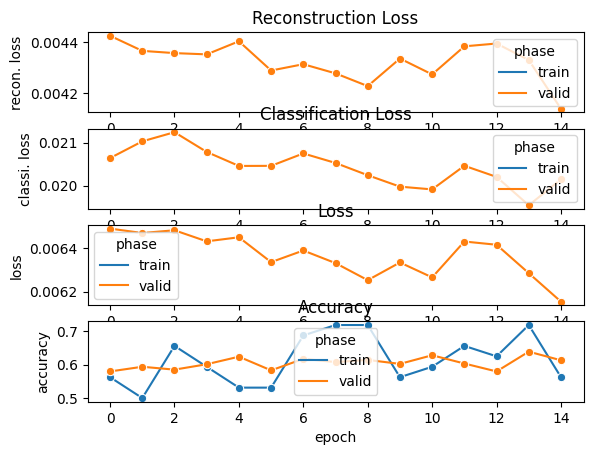

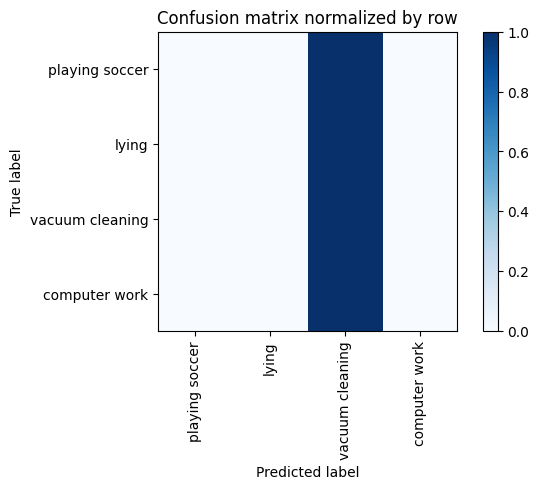

Overall accuracy: 0.219

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.000      0.000      0.000      0.406         13|	 vacuum cleaning: 1.000,	lying: 0.000,	
          lying       0.000      0.000      0.000      0.344         11|	 vacuum cleaning: 1.000,	computer work: 0.000,	
vacuum cleaning       0.219      1.000      0.359      0.219          7|	 computer work: 0.000,	lying: 0.000,	
 playing soccer       0.000      0.000      0.000      0.031          1|	 vacuum cleaning: 1.000,	computer work: 0.000,	lying: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.048      0.219      0.079        1.0         32|	      

{'accuracy': 0.21875, 'precision': 0.0546875, 'recall': 0.25, 'f1': 0.08974358974358974}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
seen classes >  ['lying', 'sittin

Training Epoch:   7%|▋         | 1/15 [01:05<15:19, 65.66s/it]

Overall accuracy: 0.593



Training Epoch:  13%|█▎        | 2/15 [02:18<15:11, 70.13s/it]

Overall accuracy: 0.596



Training Epoch:  20%|██        | 3/15 [03:28<13:56, 69.72s/it]

Overall accuracy: 0.593



train: 100%|██████████| 33/33 [00:06<00:00,  4.89batch/s, loss=0.238]


Overall accuracy: 0.602



Training Epoch:  33%|███▎      | 5/15 [3:53:44<9:47:17, 3523.75s/it] 

Overall accuracy: 0.611



Training Epoch:  40%|████      | 6/15 [3:54:40<5:51:41, 2344.67s/it]

Overall accuracy: 0.630



Training Epoch:  47%|████▋     | 7/15 [3:55:39<3:33:00, 1597.50s/it]

Overall accuracy: 0.634



Training Epoch:  53%|█████▎    | 8/15 [3:56:36<2:09:09, 1107.07s/it]

Overall accuracy: 0.663



Training Epoch:  60%|██████    | 9/15 [3:57:41<1:18:08, 781.41s/it] 

Overall accuracy: 0.616



Training Epoch:  67%|██████▋   | 10/15 [3:58:47<46:41, 560.37s/it] 

Overall accuracy: 0.633



Training Epoch:  73%|███████▎  | 11/15 [3:59:46<27:08, 407.14s/it]

Overall accuracy: 0.638



Training Epoch:  80%|████████  | 12/15 [4:00:54<15:11, 303.83s/it]

Overall accuracy: 0.633



Training Epoch:  87%|████████▋ | 13/15 [4:02:03<07:45, 232.63s/it]

Overall accuracy: 0.616



Training Epoch:  93%|█████████▎| 14/15 [4:03:09<03:02, 182.42s/it]

Overall accuracy: 0.659



train: 100%|██████████| 33/33 [00:02<00:00, 13.75batch/s, loss=0.248]


Overall accuracy: 0.630



100%|██████████| 66/66 [00:00<00:00, 397.66batch/s]


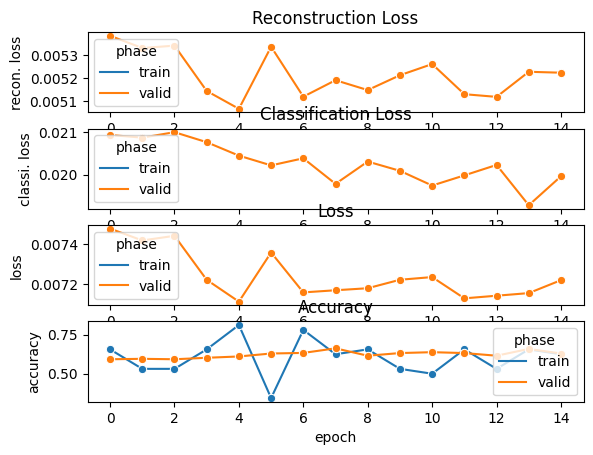

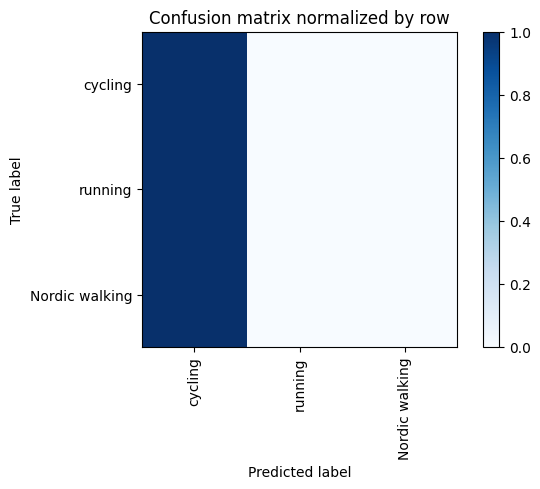

Overall accuracy: 0.219

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.469         15|	 cycling: 1.000,	running: 0.000,	
       running       0.000      0.000      0.000      0.312         10|	 cycling: 1.000,	Nordic walking: 0.000,	
       cycling       0.219      1.000      0.359      0.219          7|	 Nordic walking: 0.000,	running: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.048      0.219      0.079        1.0         32|	      

{'accuracy': 0.21875, 'precision': 0.07291666666666667, 'recall': 0.3333333333333333, 'f1': 0.11965811965811966}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'watching TV', 'computer work', 'ascending stairs', 'd

Training Epoch:   7%|▋         | 1/15 [01:01<14:27, 61.99s/it]

Overall accuracy: 0.608



train:  82%|████████▏ | 253/307 [00:50<00:10,  5.04batch/s, loss=0.619, classi. loss=0.672, recon. loss=0.149]


KeyboardInterrupt: 

In [75]:
# run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = [all_classes[i] for i in data_dict['seen_classes']]
    unseen_classes = [all_classes[i] for i in data_dict['unseen_classes']]
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    # train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = BaseDataset(imu_data=data_dict['train']['X'], imu_actions=data_dict['train']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=seen_classes, skel_len=timestamps)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = BaseDataset(imu_data=data_dict['eval-seen']['X'], imu_actions=data_dict['eval-seen']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=seen_classes, skel_len=timestamps)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = UnseenDataset(imu_data=data_dict['test']['X'], imu_actions=data_dict['test']['y'], skel_data=skeleton_mov, skel_label=skeleton_classes, action2label=action2label, active_cls=unseen_classes, skel_len=timestamps)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = BaseModel(base_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_modules = {'classi': nn.BCELoss(), 'recon': nn.L1Loss()}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, optimizer, loss_modules, device, phase='train', loss_alpha=config['loss_alpha'])
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        # log(i, 'train', train_metrics)

        eval_metrics = validate_step(model, eval_dl, optimizer, loss_modules, device, seen_classes, phase='train', loss_alpha=config['loss_alpha'], print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = unseen_eval(model, test_dl, device, unseen_classes, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    # log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
# log('global', '',seen_score_df.mean().to_dict())
# run.stop()

100%|██████████| 84/84 [00:00<00:00, 120.04batch/s]


torch.Size([4, 32, 60, 24])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] [1 1 2 2 1 0 3 2 3 2 0 3 0 0 3 3 3 2 2 0 1 2 3 0 2 3 1 2 2 0 1 1]


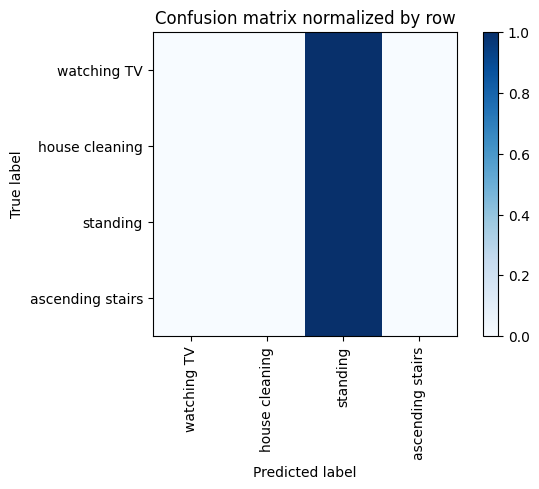

Overall accuracy: 0.312

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.312      1.000      0.476      0.312         10|	 ascending stairs: 0.000,	house cleaning: 0.000,	
ascending stairs       0.000      0.000      0.000      0.250          8|	 standing: 1.000,	house cleaning: 0.000,	
  house cleaning       0.000      0.000      0.000      0.219          7|	 standing: 1.000,	ascending stairs: 0.000,	
     watching TV       0.000      0.000      0.000      0.219          7|	 standing: 1.000,	ascending stairs: 0.000,	house cleaning: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.098      0.312      0.149        1.0         32|	      



In [53]:
test_metrics = unseen_eval(model, test_dl, device, unseen_classes, print_report=True, show_plot=True)
fold_metric_scores.append(test_metrics)

In [ ]:
torch.cuda.empty_cache()